
# Final Project 2: Data Transformation to Improve Generalization of Model Predictions

## Experiment Setup:
MAKE A custom transformation class to apply Gaussian noise to input images. This simulates tampered data. 

Two models will be trained on each dataset (MNIST and Fashion MNIST):

        - Model A: Trained on the clean dataset.

        - Model B: Trained on the tampered (noisy) dataset.

Both models will be evaluated on test datasets with:
        
        Clean images

        Noisy images (gaussian noise with increasing standard deviation)

## Hypothesis:
    Clean-trained Model: Will perform well on clean test data but poorly on noisy data due to its sensitivity to tampered input and potential overfitting.

    Tampered Model :Will perform robustly on both clean and noisy test data.
  
    Training on Fashion MNIST: this dataset is more complex compared to MNIST, making it an good comparison point to investigate if adding noise has a consistent effect across datasets, or if dataset complexity influences how models learn from noisy data.

# Questions: 
    How well does a CNN generalize to unseen noisy input images?
    Does training on noisy images improve model robustness?
    Is the impact of noise training more significant on more complex datasets?
 

In [13]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 31
torch.manual_seed(seed)
np.random.seed(seed)

In [14]:
#SETP 1: SET UP THE GAUSSIAN NOISE TO ADD TO THE IMAGES. 
'''
set up the gaussian noise as a class so that it works with transforms.compose
'''
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.2):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
             #ensure the random ttorch tensor is same scale as tensor image. 
            #scale the noise to chosen mean and std (althought prob wont touch mean)
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

'''
From my previous project I first change the data loading. 
I take this transform.compose portion: 
- transforms.compose() is a way to chain multiple image transformations together into one operation. 

Model clean: trained on clean
- the transforms essentially just normalizes the inputs

Model tampered: trained on noisy data
- add some gaussian noise to transform 

'''
#model clean
transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#model tampered
transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0, 0.5), 
    transforms.Normalize((0.1307,), (0.3081,))
])


In [15]:
'LOAD DATASET MNIST and APPLY TRANSFORM'
mnist_clean = datasets.MNIST(root='.', train=True, download=True, transform=transform_clean)
mnist_noisy = datasets.MNIST(root='.', train=True, download=True, transform=transform_noisy)


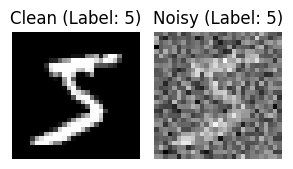

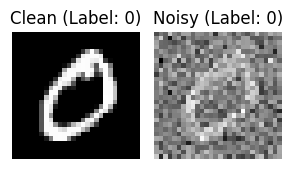

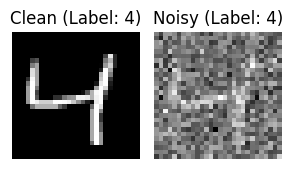

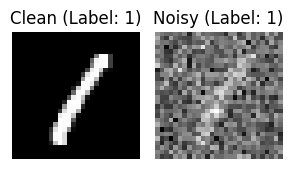

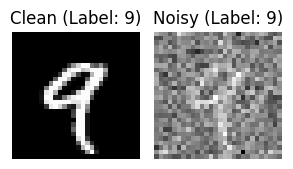

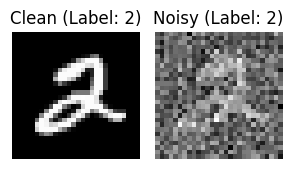

In [16]:
def show_clean_vs_noisy(indices, ds_clean, ds_noisy):
    for index in indices: 
        clean_img, label = ds_clean[index]
        noisy_img, label = ds_noisy[index]
        fig, axs = plt.subplots(1, 2, figsize=(3, 3))
        axs[0].imshow(clean_img.squeeze(), cmap='gray')
        axs[0].set_title(f'Clean (Label: {label})')
        axs[0].axis('off')
        axs[1].imshow(noisy_img.squeeze(), cmap='gray')
        axs[1].set_title(f'Noisy (Label: {label})')
        axs[1].axis('off')
    
        plt.tight_layout()
        plt.show()
    
show_clean_vs_noisy([0,1,2,3,4,5], mnist_clean, mnist_noisy)  

In [17]:
'''
DataLoaders: lets iteration through batches. 
'''
train_loader_clean = DataLoader(mnist_clean, batch_size=128, shuffle=True)
train_loader_noisy = DataLoader(mnist_noisy, batch_size=128, shuffle=True)

'load data and make dataload for test'
testset_clean = datasets.MNIST(root='.', train=False, transform=transform_clean)
testset_noisy = datasets.MNIST(root='.', train=False, transform=transform_noisy)

test_loader_clean = DataLoader(testset_clean, batch_size=1, shuffle=False)
test_loader_noisy = DataLoader(testset_noisy, batch_size=1, shuffle=False)



In [84]:
'''CNN architecture: 
- 3 convolutional layes 
- 3 pooling layers

To speed things up I could: 
- reduce the parameters the conv2d layer 
- larger batch size can speed things up, but might require adjusting the learning rate
'''
def get_new_cnn():
    cnnEncoder = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=3, stride=1),         
        nn.MaxPool2d(kernel_size=2, stride=2),             
        nn.Conv2d(4, 16, kernel_size=3, stride=1, padding=1), 
        nn.MaxPool2d(kernel_size=2, stride=2),        
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2),            
        nn.Flatten()
    )

    linearClassifier = nn.Sequential(
        nn.Linear(32 * 3 * 3, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )

    return nn.Sequential(cnnEncoder, linearClassifier)

''' 
EVALUATE : ACCURACY 
'''
def evaluate(model, test_loader):
    model.eval()
    correct =0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct+= (pred == target).sum().item()
            total+=target.size(0)
    accuracy = 100. * correct/ total
    return accuracy

''' 
EVALUATE LOSS_ confidence on wrong labels
'''
def evaluate_loss(model, dataloader, criterion):
    model.eval()
    total_loss= 0
    with torch.no_grad():
        for data, target in dataloader: 
            data= data.to(device)
            target= target.to(device)
            output= model(data)
            loss= criterion(output, target) 
            total_loss+= loss.item()
    return total_loss/len(dataloader)

def train_cnn(num_epochs, model, dataloader, optimizer):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_clean= []
    test_noisy=[]
    
    clean_accuracy= []
    noisy_accuracy= []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        '''AFTER EACH EPOCH EVALUATE TEST SET LOSS'''
        test_clean.append(evaluate_loss(model, test_loader_clean, criterion))
        test_noisy.append(evaluate_loss(model, test_loader_noisy, criterion))

    
        '''AFTER EACH EPOCH EVALUATE TEST SET ACCURACY'''
        clean_accuracy.append(evaluate(model, test_loader_clean))
        noisy_accuracy.append(evaluate(model, test_loader_noisy))
        
    return train_losses, test_clean, test_noisy, clean_accuracy, noisy_accuracy


In [85]:
'''TRAIN: '''
cnnA= get_new_cnn()
optimiserA= torch.optim.SGD(cnnA.parameters(), lr= 0.01, momentum=0.9)
loss_A, Atest_loss_clean, Atest_loss_noisy, Aclean_accuracy, Anoisy_accuracy = train_cnn(20, cnnA, train_loader_clean, optimiserA)


Epoch [1/20], Loss: 0.4185
Epoch [2/20], Loss: 0.0805
Epoch [3/20], Loss: 0.0565
Epoch [4/20], Loss: 0.0465
Epoch [5/20], Loss: 0.0379
Epoch [6/20], Loss: 0.0309
Epoch [7/20], Loss: 0.0271
Epoch [8/20], Loss: 0.0220
Epoch [9/20], Loss: 0.0209
Epoch [10/20], Loss: 0.0179
Epoch [11/20], Loss: 0.0142
Epoch [12/20], Loss: 0.0121
Epoch [13/20], Loss: 0.0128
Epoch [14/20], Loss: 0.0085
Epoch [15/20], Loss: 0.0100
Epoch [16/20], Loss: 0.0076
Epoch [17/20], Loss: 0.0074
Epoch [18/20], Loss: 0.0060
Epoch [19/20], Loss: 0.0057
Epoch [20/20], Loss: 0.0060


In [86]:
cnnB = get_new_cnn()
optimiserB = torch.optim.SGD(cnnB.parameters(), lr=0.01, momentum=0.9)
loss_B, Btest_loss_clean, Btest_loss_noisy, Bclean_accuracy, Bnoisy_accuracy  = train_cnn(20, cnnB, train_loader_noisy, optimiserB)

Epoch [1/20], Loss: 0.5985
Epoch [2/20], Loss: 0.2068
Epoch [3/20], Loss: 0.1696
Epoch [4/20], Loss: 0.1463
Epoch [5/20], Loss: 0.1359
Epoch [6/20], Loss: 0.1256
Epoch [7/20], Loss: 0.1160
Epoch [8/20], Loss: 0.1082
Epoch [9/20], Loss: 0.1042
Epoch [10/20], Loss: 0.1008
Epoch [11/20], Loss: 0.0978
Epoch [12/20], Loss: 0.0970
Epoch [13/20], Loss: 0.0935
Epoch [14/20], Loss: 0.0901
Epoch [15/20], Loss: 0.0899
Epoch [16/20], Loss: 0.0870
Epoch [17/20], Loss: 0.0877
Epoch [18/20], Loss: 0.0850
Epoch [19/20], Loss: 0.0857
Epoch [20/20], Loss: 0.0836


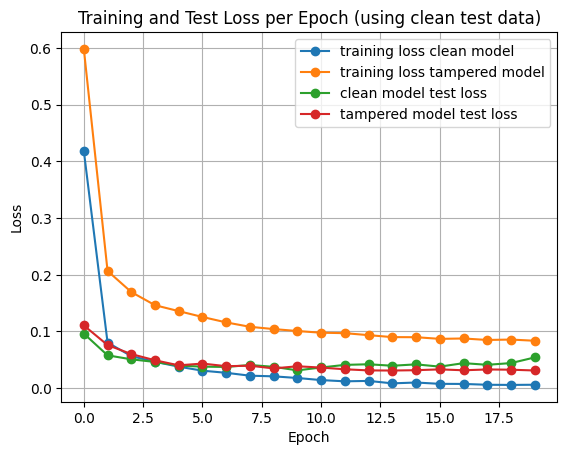

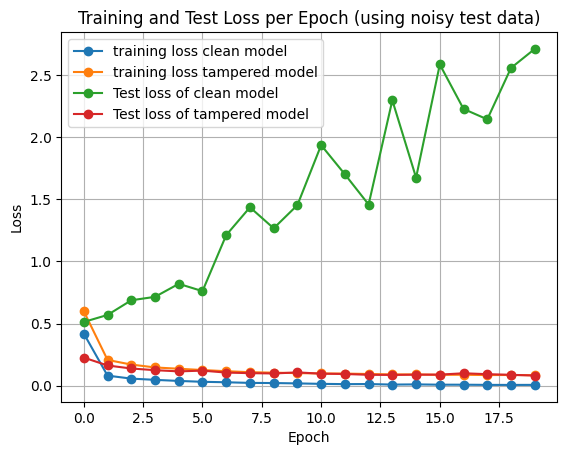

In [87]:
''' 
Plot 1: 
    Training loss of CNN A: clean model 
    Training loss of CNN B: tampered model 

    Testing on Clean data: 
    Test loss of clean model
    Test loss of tampered model

'''
plt.plot(loss_A, label='training loss clean model', marker='o')
plt.plot(loss_B, label='training loss tampered model', marker='o')

plt.plot(Atest_loss_clean, label='clean model test loss', marker='o')
plt.plot(Btest_loss_clean, label='tampered model test loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch (using clean test data)')
plt.legend()
plt.grid(True)
plt.show()



'''
Plot 2:  
    Difference in training loss per epoch and the test loss against noisy data
'''
plt.plot(loss_A, label='training loss clean model', marker='o')
plt.plot(loss_B, label='training loss tampered model', marker='o')

plt.plot(Atest_loss_noisy, label='Test loss of clean model' , marker='o')
plt.plot(Btest_loss_noisy, label='Test loss of tampered model', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch (using noisy test data)')
plt.legend()
plt.grid(True)
plt.show()

# CLEAN MODEL : 
**TRAINING**
- clean model's training loss converges to a lower value than the training loss of the tampered model
- clean model converges to zero

**CLEAN DS TESTING**
- clean model test loss on clean ds is higher than its training loss which suggests the model might have been memorizing the training data set
- clean model test

**NOISY DS TESTING**
- test loss diverges!
- this suggests it cannot decode noisy images


# TAMPERED MODEL
**TRAINING**
- tampered model convereges at a higher training loss than the clean model
- this suggests the model is likely struggling more because the 

**CLEAN DS TESTING**
- clean model test loss on clean ds is higher than its training loss which suggests the model might have been memorizing the training data set
- clean model test

**NOISY DS TESTING**
- test loss diverges!
- this suggests it cannot decode noisy images


The clean model is confused when shown noisy images 
The tampered model learned the noisy patterns and is more certain when exposed to both noisy and clean images. 

## Accuracy of the models vs Loss
Loss of the clean model increased with noisy data while staying accurate. This means despite the model performing well, it is exhibiting an overconfidence in wrong labels. 
The tampered model exhibits lower losses (so more confidence in the correct labels) and a high accuracy. 

This difference suggets despite both models showing good performance in acuracy their test loss shows the clean model is more confused whereas the tampered model is better at selecting the correct label with confidence. 

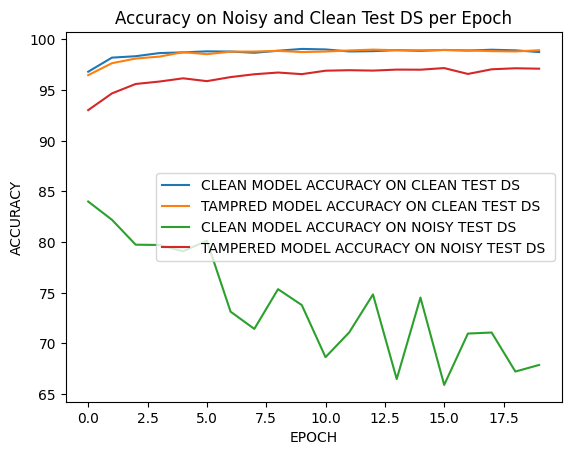

In [89]:
plt.plot(Aclean_accuracy, label= 'CLEAN MODEL ACCURACY ON CLEAN TEST DS')
plt.plot(Bclean_accuracy, label= 'TAMPRED MODEL ACCURACY ON CLEAN TEST DS')

plt.plot(Anoisy_accuracy , label= 'CLEAN MODEL ACCURACY ON NOISY TEST DS ')
plt.plot(Bnoisy_accuracy , label= 'TAMPERED MODEL ACCURACY ON NOISY TEST DS ')

plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('Accuracy on Noisy and Clean Test DS per Epoch')
plt.legend()
plt.show()


## Result: 
#### - We see high accuracy of the clean model and the tampered model when exposed to a clean test set
#### - however we see accuracy is much lower when the clean model is exposed to the noisy test set
#### - whereas the tampered model performs well on the noisy test set , however not as well as on the clean test set.


# Comparing Weight Norms model clean and model tampered: 
- The model with the smaller weight vector norm would indicate its weight vector is simpler and therefoce would indicate the weight vector is quite
  

In [94]:
def compute_weight_norm(model):
    norm = 0.
    for param in model.parameters():
        if param.requires_grad:
            norm += torch.norm(param.data, p=2).item() ** 2
    return norm ** 0.5

print("Weight norm of Clean-trained model:", compute_weight_norm(cnnA))
print("Weight norm of Tampered model:", compute_weight_norm(cnnB))

Weight norm of Clean-trained model: 12.105566311609088
Weight norm of Tampered model: 12.458847605965591


#### The comparison between the clean model's and the tampered model's weight vector norms indicates that the tampered model has a slightly higher overall weight magnitude. This suggests that it relied more heavily on its learned features to fit the noisier training data, potentially making it more sensitive to input variations

# Accuracy vs different levels of noise: 
- Vary different levels of noise and see how that affects the accuracy to see how much noise the models can take 

In [91]:
'''First make different noise level test sets: '''

# 0.2 stdev
transform_noisy_2 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0, 0.2),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 0.4 stdev
transform_noisy_4 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0, 0.4),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 0.6 stdev
transform_noisy_6 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0, 0.6),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 0.8 stdev
transform_noisy_8 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0, 0.8),
    transforms.Normalize((0.1307,), (0.3081,))
])

'LOAD DATASET MNIST and APPLY TRANSFORM'
mnist_clean = datasets.MNIST(root='.', train=True, download=True, transform=transform_clean)
mnist_noisy = datasets.MNIST(root='.', train=True, download=True, transform=transform_noisy)

test_clean =datasets.MNIST(root='.', train=False, transform=transform_clean, download=True)
test_mild = datasets.MNIST(root='.', train=False, transform=transform_noisy_2)
test_moderate = datasets.MNIST(root='.', train=False, transform=transform_noisy_4)
test_moderate_strong = datasets.MNIST(root='.', train=False, transform=transform_noisy_6)
test_strong = datasets.MNIST(root='.', train=False, transform=transform_noisy_8)

#test loaders.
batch_size = 64
test_loader_clean = DataLoader(test_clean, batch_size=batch_size, shuffle=False)
test_loader_mild = DataLoader(test_mild, batch_size=batch_size, shuffle=False)
test_loader_moderate = DataLoader(test_moderate, batch_size=batch_size, shuffle=False)
test_loader_moderate_strong = DataLoader(test_moderate_strong, batch_size=batch_size, shuffle=False)
test_loader_strong = DataLoader(test_strong, batch_size=batch_size, shuffle=False)


test_loaders = [test_loader_clean, test_loader_mild, test_loader_moderate, test_loader_moderate_strong, test_loader_strong]
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]

accuracies_A = []
accuracies_B = []

for cnn in [cnnA, cnnB]:
    for stdev, test_loader in zip(noise_levels, test_loaders):
        accuracy = evaluate(cnn, test_loader)
        if cnn == cnnA:
            accuracies_A.append(accuracy)
        elif cnn == cnnB:
            accuracies_B.append(accuracy)



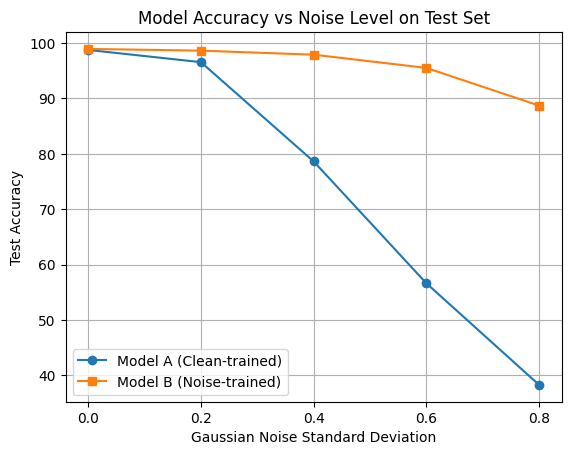

In [92]:
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]
plt.plot(noise_levels, accuracies_A, marker='o', label='Model A (Clean-trained)')
plt.plot(noise_levels, accuracies_B, marker='s', label='Model B (Noise-trained)')

plt.xlabel('Gaussian Noise Standard Deviation')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy vs Noise Level on Test Set')
plt.xticks(noise_levels)
plt.grid(True)
plt.legend()
plt.show()

## Here we see the accuracy of of the clean model when exposed to datasets with higher than 0.2 stdev noise quickly decreases, whereas the tampered model performs with quite high accuracy in all the stdevs and only significatnly decreases 10% accuracy once the noises stdev reaches 0.8 which is a strong noisy transformation. 

## Fashion MNIST

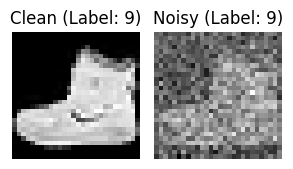

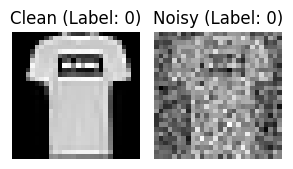

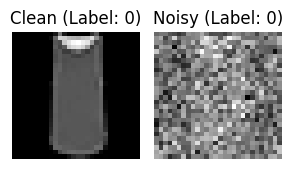

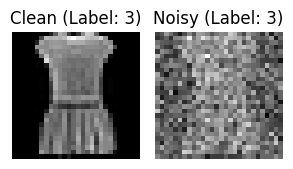

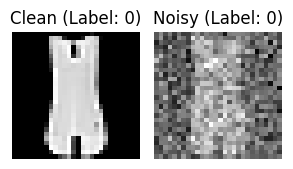

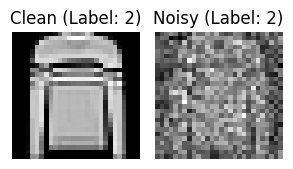

In [95]:
#like before I make a clean and noisy transforms using AddGaussianNoise class
transform_fashion_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_fashion_noisy = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.4),  # you can increase std later
    transforms.Normalize((0.5,), (0.5,))
])

#apply respective transform
trainset_clean = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform_fashion_clean)
trainset_noisy = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform_fashion_noisy)
testset_clean = datasets.FashionMNIST(root='.', train=False, download=True, transform=transform_fashion_clean)
testset_noisy = datasets.FashionMNIST(root='.', train=False, download=True, transform=transform_fashion_noisy)

train_loader_clean = torch.utils.data.DataLoader(trainset_clean, batch_size=128, shuffle=True)
train_loader_noisy = torch.utils.data.DataLoader(trainset_noisy, batch_size=128, shuffle=True)
test_loader_clean = torch.utils.data.DataLoader(testset_clean, batch_size=128, shuffle=False)
test_loader_noisy = torch.utils.data.DataLoader(testset_noisy, batch_size=128, shuffle=False)

show_clean_vs_noisy([0,1,2,3,4,5] ,trainset_clean, trainset_noisy) 


fashion_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


In [96]:

modelA_fashion = get_new_cnn()
optimiserAf= torch.optim.SGD(modelA_fashion.parameters(), lr= 0.01, momentum=0.9)
loss_Af, Aftest_loss_clean, Aftest_loss_noisy, Afclean_accuracy, Afnoisy_accuracy = train_cnn(20, modelA_fashion, train_loader_clean, optimiserAf)

modelB_fashion = get_new_cnn()
optimiserBf= torch.optim.SGD(modelB_fashion.parameters(), lr= 0.01, momentum=0.9)
loss_Bf, Bftest_loss_clean, Bftest_loss_noisy, Bfclean_accuracy, Bfnoisy_accuracy = train_cnn(20, modelB_fashion, train_loader_noisy, optimiserBf)


Epoch [1/20], Loss: 0.7794
Epoch [2/20], Loss: 0.4243
Epoch [3/20], Loss: 0.3588
Epoch [4/20], Loss: 0.3210
Epoch [5/20], Loss: 0.2930
Epoch [6/20], Loss: 0.2739
Epoch [7/20], Loss: 0.2603
Epoch [8/20], Loss: 0.2506
Epoch [9/20], Loss: 0.2411
Epoch [10/20], Loss: 0.2327
Epoch [11/20], Loss: 0.2242
Epoch [12/20], Loss: 0.2152
Epoch [13/20], Loss: 0.2077
Epoch [14/20], Loss: 0.2031
Epoch [15/20], Loss: 0.1940
Epoch [16/20], Loss: 0.1911
Epoch [17/20], Loss: 0.1853
Epoch [18/20], Loss: 0.1774
Epoch [19/20], Loss: 0.1723
Epoch [20/20], Loss: 0.1678
Epoch [1/20], Loss: 0.8289
Epoch [2/20], Loss: 0.5498
Epoch [3/20], Loss: 0.5103
Epoch [4/20], Loss: 0.4815
Epoch [5/20], Loss: 0.4626
Epoch [6/20], Loss: 0.4571
Epoch [7/20], Loss: 0.4471
Epoch [8/20], Loss: 0.4390
Epoch [9/20], Loss: 0.4322
Epoch [10/20], Loss: 0.4257
Epoch [11/20], Loss: 0.4209
Epoch [12/20], Loss: 0.4186
Epoch [13/20], Loss: 0.4165
Epoch [14/20], Loss: 0.4126
Epoch [15/20], Loss: 0.4084
Epoch [16/20], Loss: 0.4072
Epoch [17/

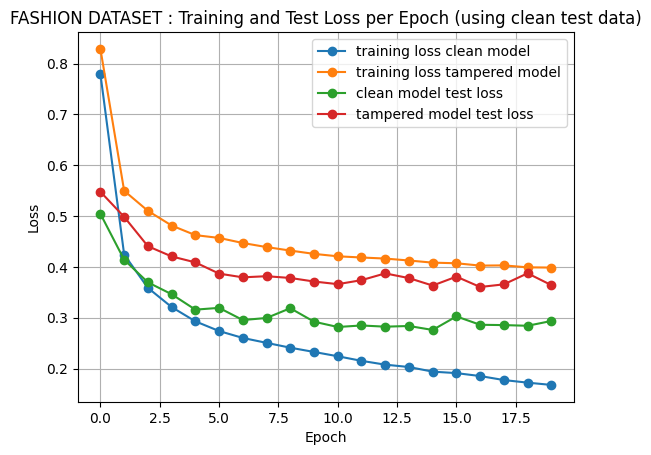

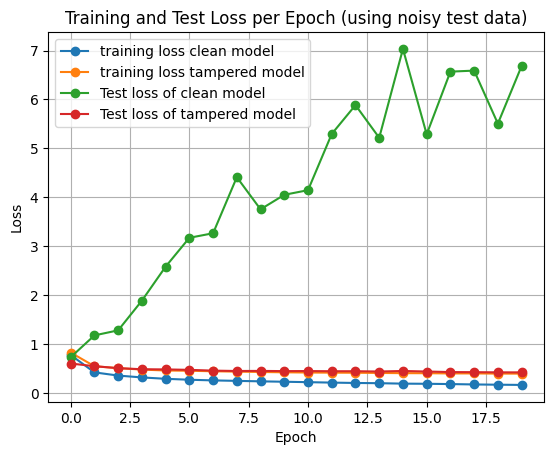

In [97]:
''' 
Plot 1: 
    Training loss of CNN A: clean model 
    Training loss of CNN B: tampered model 

    Testing on Clean data: 
    Test loss of clean model
    Test loss of tampered model

'''
plt.plot(loss_Af, label='training loss clean model', marker='o')
plt.plot(loss_Bf, label='training loss tampered model', marker='o')

plt.plot(Aftest_loss_clean, label='clean model test loss', marker='o')
plt.plot(Bftest_loss_clean, label='tampered model test loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FASHION DATASET : Training and Test Loss per Epoch (using clean test data)')
plt.legend()
plt.grid(True)
plt.show()


'''
Plot 2:  
    Difference in training loss per epoch and the test loss against noisy data
'''
plt.plot(loss_Af, label='training loss clean model', marker='o')
plt.plot(loss_Bf, label='training loss tampered model', marker='o')

plt.plot(Aftest_loss_noisy, label='Test loss of clean model' , marker='o')
plt.plot(Bftest_loss_noisy, label='Test loss of tampered model', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch (using noisy test data)')
plt.legend()
plt.grid(True)
plt.show()


## ACCURACY OF MODEL VS LOSS

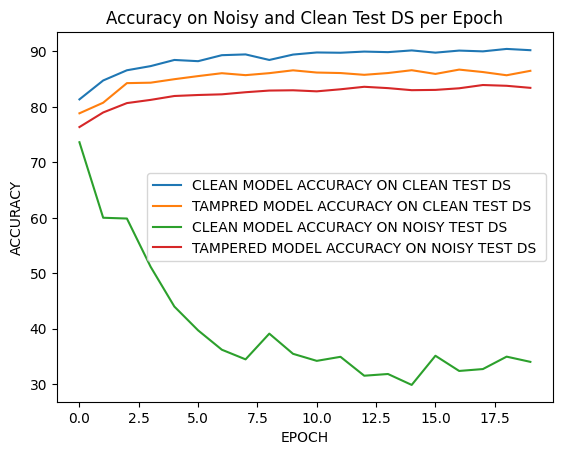

In [98]:
plt.plot(Afclean_accuracy, label= 'CLEAN MODEL ACCURACY ON CLEAN TEST DS')
plt.plot(Bfclean_accuracy, label= 'TAMPRED MODEL ACCURACY ON CLEAN TEST DS')

plt.plot(Afnoisy_accuracy , label= 'CLEAN MODEL ACCURACY ON NOISY TEST DS ')
plt.plot(Bfnoisy_accuracy , label= 'TAMPERED MODEL ACCURACY ON NOISY TEST DS ')

plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('Accuracy on Noisy and Clean Test DS per Epoch')
plt.legend()
plt.show()


## WEIGHT VECTOR NORM COMPARACENTS

In [99]:
print("Weight norm of Clean-trained model:", compute_weight_norm(modelA_fashion))
print("Weight norm of Tampered model:", compute_weight_norm(modelB_fashion))

Weight norm of Clean-trained model: 15.764904298619166
Weight norm of Tampered model: 13.195387369647783


### Here we see the weight norm of the tampered model is lower than that of the clean trained model this means it is less complex, which could indicatet he model is better generalizing. 

1. The clean model used larger weights to learn its features.
   It may have:

       -Found sharper or more confidently tuned decision boundaries from the clean data.
       -Larger weights often show stronger activation patterns for certain features.

2. The tampered model ended up with smaller weights.

    It might have:

        - Regularized itself more to avoid overfitting on noise
        - Failed to find clear signals, leading to smaller overall updates.




### Unlike the previous case where the tampered model had a higher weight norm, this time the model trained on noisy data exhibits a smaller weight norm than the clean model weight norm. 

### This suggests that the noisy training conditions may have acted as a form of implicit regularization, discouraging the model from memorizing the data and instead promoting more generalizable feature representations. In essence, the noise may have helped the model avoid overfitting by limiting the magnitude of its learned parameters.

## Accuracy vs level of noise on fashion mnist

In [101]:
'''First make different noise level test sets: '''

'LOAD DATASET MNIST and APPLY TRANSFORM'
mnist_clean = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform_clean)
mnist_noisy = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform_noisy)

test_clean =datasets.FashionMNIST(root='.', train=False, transform=transform_clean, download=True)
test_mild = datasets.FashionMNIST(root='.', train=False, transform=transform_noisy_2)
test_moderate = datasets.FashionMNIST(root='.', train=False, transform=transform_noisy_4)
test_moderate_strong = datasets.FashionMNIST(root='.', train=False, transform=transform_noisy_6)
test_strong = datasets.FashionMNIST(root='.', train=False, transform=transform_noisy_8)

#test loaders.
batch_size = 64
test_loader_clean = DataLoader(test_clean, batch_size=batch_size, shuffle=False)
test_loader_mild = DataLoader(test_mild, batch_size=batch_size, shuffle=False)
test_loader_moderate = DataLoader(test_moderate, batch_size=batch_size, shuffle=False)
test_loader_moderate_strong = DataLoader(test_moderate_strong, batch_size=batch_size, shuffle=False)
test_loader_strong = DataLoader(test_strong, batch_size=batch_size, shuffle=False)


test_loaders = [test_loader_clean, test_loader_mild, test_loader_moderate, test_loader_moderate_strong, test_loader_strong]
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]

accuracies_A = []
accuracies_B = []

for cnn in [modelA_fashion, modelB_fashion]:
    for stdev, test_loader in zip(noise_levels, test_loaders):
        accuracy = evaluate(cnn, test_loader)
        if cnn == modelA_fashion:
            accuracies_A.append(accuracy)
        elif cnn == modelB_fashion:
            accuracies_B.append(accuracy)



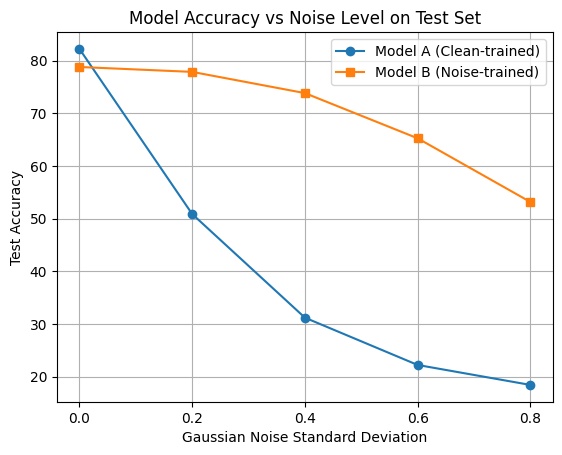

In [102]:
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8]
plt.plot(noise_levels, accuracies_A, marker='o', label='Model A (Clean-trained)')
plt.plot(noise_levels, accuracies_B, marker='s', label='Model B (Noise-trained)')

plt.xlabel('Gaussian Noise Standard Deviation')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy vs Noise Level on Test Set')
plt.xticks(noise_levels)
plt.grid(True)
plt.legend()
plt.show()

- In fashion MNIST we see a greater divergence between the clean trained model and the tampered model .
- Just like in MNIST we see the clean model quickly undeperforms the tampered model
-  We see the tampered model underperforms the tampered model in the regular number MNIST dataset which is probably due to the complexity of the images noise might impact FASHION MNIST more than number MNIST.   

# CONCLUSION :
## Training with noise improves generalization (corroborates hypothesis)
### - Introducing gaussian noise to the training data acts as a form of data augmentation and implicit regularization, helping the model learn more robust, generalizable features. 
### - As a result, the model tends to perform better on noisy or unseen test data compared to a model trained only on clean inputs.

## Impact on more complex datasets (like Fashion MNIST): 
### - For more complex datasets like Fashion MNIST, adding noise during training can help the model avoid overfitting to fine-grained patterns. 
### - This often leads to weight vectors with lower norms, which is associated with better generalization due to reduced model complexity. 
### - A lower weight norm can indicate that the model found a simpler hypothesis, aligning with the idea of implicit regularization.

